### Отчет по 3 лабе. Группа 3. Метод Ньютона с ограничениями-равенствами

In [ ]:
# %pip install cvxpy

In [ ]:
import cvxpy as cp
import numpy as np

import tqdm
import time
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

np.set_printoptions(precision=3)
sns.set_theme()

#### 1. Исследуйте задачу на выпуклость. Запишите необходимые условия минимума

Исходная задача:

$$
min\big{[}(1 + x_1^2)^{1/2} + \sum_{i=1}^{n-1}(1 + (x_{i+1}-x_i)^2)^{1/2} \big{]}\\
Ax = b \\
x \in \mathbb{R}^n,
A \in \mathbb{R}^{m \times n},
x \in \mathbb{R}^m
$$


Далее эту задачу будем решать методом Ньютона с ограничениями-равенствами, поэтому должны нужно вычислить градиент и матрицу вторых производных:

$$
\nabla f_0(x) =
\begin{pmatrix}
\frac{x_1}{\sqrt{x_1^2+1}}-\frac{x_2-x_1}{\sqrt{(x_2-x_1)^2+1}} \\
\vdots\\
\frac{x_i-x_{i-1}}{\sqrt{\left( x_i-x_{i-1}\right)^2+1}}-\frac{x_{i+1}-x_i}{\sqrt{(x_{i+1}-x_{i})^2+1}}  \\
\vdots\\
\frac{x_n-x_{n-1}}{\sqrt{\left(x_n-x_{n-1} \right)^2+1}}
\end{pmatrix}, \ где \ i=\overline{2, n-1}
$$


$$
\frac{d}{dx_i}
\left(
{x_{i+1}-x_i}
\over{{\left( {\left( x_{i+1}-x_i\right)}^2+1\right)}^{1/2}}
\right)
= \dots = -\frac{1}{{\left( \left( x_{i+1}-x_i\right)^2+1\right)^{3/2}}}
= -\frac{d}{dx_{i+1}}  \left( \frac{x_{i+1}-x_i}{{\left( \left( x_{i+1}-x_i\right)^2+1\right)^{1/2}}}\right)
$$

Тогда
$$z(i) = \frac{1}{\left(\left(x_{i+1}-x_{i}\right)^2+1\right)^{3/2}}$$

Тогда:
$$
H(x)=
\begin{pmatrix}
\frac{1}{\left(x_1^2+1\right)^{3/2}} + z(1) & -z(1) &  0 & 0 & ... & 0\\
-z(1) & z(1) + z(2) & -z(2) & 0 & ... & 0\\
0 & -z(2) & z(2) + z(3) & -z(3) & ... & 0\\
\vdots\\
\underbrace{0 \ \ \ \ \ \ \ ...\ \ \ \  0}_\text{i-2} &  -z(i-1) & z(i-1) + z(i) & -z(i) & ... & 0\\
\vdots\\
0 & ... & ... & -z(n-2)  & z(n-2) + z(n-1) & -z(n-1)\\
0 & ... & ... & 0  & -z(n-1) & z(n-1)
\end{pmatrix}, \\\forall_i=\overline{2, n-1}
$$

Искомая функция выпукла, так как матрица Гессе положительно определена(?).

$\frac{1}{\left(x_1^2+1\right)^{3/2}} + z(1) > 0$

$(\frac{1}{\left(x_1^2+1\right)^{3/2}} + z(1)) \cdot (z(1) + z(2)) - z(1)^2 > 0$

И т.д. (?)

Для трехдиагональной матрицы определитель задается рекуррентной формулой $f_n = (z(i-1) + z(i)) * f_{n-1} - z(i-1)^2 * f_{n-2}$.

Методом математической индукции решение не удалось найти (в индукционном переходе ничего не сократилось).

На паре вывели условия минимума:

\begin{equation*}
 \begin{cases}
   H(x^{(k)}) \cdot x + A^T\mu = - \nabla f_0(x^{(k)}) + H(x^{(k)})\cdot x^{(k)},
   \\
   Ax + 0 \cdot \mu = b
 \end{cases}
\end{equation*}



Это можно записать в следующем виде:

$$
    \begin{pmatrix}
    H(x^{(k)}) & A^T\\\\
    A & 0\\\\
    \end{pmatrix} \times \begin{pmatrix} x\\\\ \mu
    \end{pmatrix} =\begin{pmatrix} H(x^{(k)}) \cdot x^{(k)} - \nabla f_0(x^{(k)}) \\\\b\end{pmatrix}
$$

### 2. Решение с помощью CVX

In [ ]:
gena = np.random.default_rng(42)

n_range = np.arange(10, 101, 10)
m_range = (n_range * .5).astype(int)
N = 100
data = {}

pbar = tqdm.tqdm(total=n_range.shape[0]*N, position=0, leave=True)
for n, m in zip(n_range, m_range):
  data[n] = {}
  i = 0
  while i < N:
    A = gena.normal(size=(m, n))
    b = gena.normal(size=(m))

    x = cp.Variable(n)
    obj = cp.Minimize(cp.norm(cp.vstack((1, x[0])), 2) +
                      cp.sum([cp.norm(cp.vstack((1, x[j + 1] - x[j])), 2) for j in range(0, n-1)]))
    constraints = [A @ x == b]

    prob = cp.Problem(obj, constraints)
    try:
      prob.solve(verbose = False)
    except cp.SolverError:
      prob.solve(solver=cp.SCS, verbose = False)
    if x.value is None:
      print(f"No solution for x: {x}")
      continue
    # print("Optimal value: ", prob.value)
    # print("Optimal solution: ", x.value)
    data[n][i] = {}
    data[n][i]['A'] = A
    data[n][i]['b'] = b
    data[n][i]['x_true'] = x.value
    data[n][i]['y_true'] = prob.value
    i += 1
    pbar.update(1)

100%|██████████| 1000/1000 [02:06<00:00,  4.60it/s]

### 3. Решение прямой задачи методом Ньютона

In [ ]:
def make_z(x):
  def z(i):
    return 1 / np.power((x[i + 1] - x[i]) ** 2 + 1, 3/2)
  return z

def make_t(x):
  def t(i):
    return (x[i + 1] - x[i]) / np.sqrt((x[i + 1] - x[i]) ** 2 + 1)
  return t

# Гессе
def make_h(x):
  n = x.shape[0]
  h = np.zeros((n, n))
  z = make_z(x)

  h[0][0] = 1 / np.power(x[0] ** 2 + 1, 3/2) + z(0)
  h[0][1] = -z(0)
  for i in range(1, n - 1):
    h[i][i - 1] = -z(i - 1)
    h[i][i] = z(i - 1) + z(i)
    h[i][i + 1] = -z(i)
  h[n-1][n-1] = z(n-2)
  h[n-1][n-2] = -z(n-2)
  return h

# Градиент
def make_grad(x):
  n = x.shape[0]
  grad = np.zeros((n))
  t = make_t(x)

  grad[0] = x[0] / np.sqrt(x[0] ** 2 + 1) - t(0)
  for i in range(1, n - 1):
    grad[i] = t(i - 1) - t(i)
  grad[n - 1] = t(n - 2)
  return grad

# Подсчет функции
def calc_f(x):
    return np.sqrt(1 + x[0]**2) + np.sum([np.sqrt(1 + (x[i+1]-x[i])**2) for i in range(x.shape[0] - 1)])

def make_projection(x, A, b):
  return x - A.T @ np.linalg.inv(A @ A.T) @ (A @ x - b)

#### Способ 1. Как на лекции

$$
    \begin{pmatrix}
    H(x^{(k)}) & A^T\\\\
    A & 0\\\\
    \end{pmatrix} \times \begin{pmatrix} x\\\\ \mu
    \end{pmatrix} =\begin{pmatrix} H(x^{(k)}) \cdot x^{(k)} - \nabla f_0(x^{(k)}) \\\\b\end{pmatrix}
$$

In [ ]:
def iter_newton(x, A, b):
  left_mtx = np.block([[make_h(x), -A.T],[A, np.zeros(shape=(A.shape[0], A.shape[0]))]])
  right_mtx = np.concatenate((-make_grad(x) + make_h(x) @ x, b))
  return np.linalg.solve(left_mtx, right_mtx)[:x.shape[0]]

In [ ]:
n_starts = 100
eps = 0.01
max_iters = 100

for n, m in zip(n_range, m_range):
    for i in range(N):
        data[n][i]["no_sol_cnt"] = 0
        for start in range(n_starts):

            x = gena.normal(size=(n))
            mu = np.zeros(shape=(m))
            A = data[n][i]["A"]
            b = data[n][i]["b"]
            y_true = data[n][i]["y_true"]

            x = make_projection(x, A, b)
            data[n][i][f"x_{start}"] = x

            iter_cnt = 0
            print(f'Step = {iter_cnt}, {x=}')
            while not np.isclose(calc_f(x), y_true, atol=eps):
                iter_cnt += 1
                x = iter_newton(x, A, b)
                print(f'Step = {iter_cnt}, {x=}')
                if iter_cnt == max_iters:
                    data[n][i]["no_sol_cnt"] += 1
                    break

            pbar.update(1)

Step = 0, x=array([-0.00490602,  0.94923347, -0.19595159, -0.3839993 ,  0.1351434 ,
       -0.94106048,  0.01798234, -0.36241515, -1.05099006, -0.8085192 ])
Step = 1, x=array([ 0.07014734,  1.47795229, -0.6205379 , -1.50720428,  0.01280278,
       -2.43171812,  0.41448422, -0.34591711, -1.64030883, -0.4180351 ])
Step = 2, x=array([  0.33159007,   2.45380867,  -6.25254413,  -9.9400278 ,
        -0.01693044, -15.03812097,   2.21959765,  -0.10384238,
        -4.09250572,   3.77383661])
Step = 3, x=array([-1.15076164e+00, -2.09159518e+01, -1.05395653e+03, -1.20657413e+03,
       -1.16468211e+02, -1.88999028e+03,  2.28883688e+01,  1.39494817e-01,
       -9.58259783e+01,  9.23915623e+02])
Step = 4, x=array([-3.56220220e+02, -8.25992796e+04, -5.42761324e+08, -6.33635160e+08,
       -8.27908250e+07, -9.63131160e+08, -1.01306845e+07, -9.85126097e+06,
       -2.29748390e+07,  4.86140015e+08])
Step = 5, x=array([ 9.22720492e+08, -5.27455695e+15, -9.29728640e+25, -1.09759613e+26,
       -1.4607162

/tmp/ipykernel_34/1704270142.py:41: RuntimeWarning: overflow encountered in double_scalars
  return np.sqrt(1 + x[0]**2) + np.sum([np.sqrt(1 + (x[i+1]-x[i])**2) for i in range(x.shape[0] - 1)])
/tmp/ipykernel_34/1704270142.py:17: RuntimeWarning: overflow encountered in double_scalars
  h[0][0] = 1 / np.power(x[0] ** 2 + 1, 3/2) + z(0)
/tmp/ipykernel_34/1704270142.py:3: RuntimeWarning: overflow encountered in double_scalars
  return 1 / np.power((x[i + 1] - x[i]) ** 2 + 1, 3/2)
/tmp/ipykernel_34/1704270142.py:33: RuntimeWarning: overflow encountered in double_scalars
  grad[0] = x[0] / np.sqrt(x[0] ** 2 + 1) - t(0)
/tmp/ipykernel_34/1704270142.py:8: RuntimeWarning: overflow encountered in double_scalars
  return (x[i + 1] - x[i]) / np.sqrt((x[i + 1] - x[i]) ** 2 + 1)


LinAlgError: Singular matrix

#### Способ 2.  KKT system

$$
    \begin{pmatrix}
    H(x^{(k)}) & A^T\\\\
    A & 0\\\\
    \end{pmatrix} \times \begin{pmatrix} x^*\\\\\mu^*
    \end{pmatrix} =\begin{pmatrix} -\nabla f_0(x^{(k)}) \\\\b\end{pmatrix}
$$

In [ ]:
def iter_newton(x, A, b):
  left_mtx = np.block([[make_h(x), A.T],[A, np.zeros(shape=(A.shape[0], A.shape[0]))]])
  right_mtx = np.concatenate((-make_grad(x), b))
  return np.linalg.solve(left_mtx, right_mtx)[:x.shape[0]]

In [ ]:
n_starts = 100
eps = 0.01
max_iters = 100

for n, m in zip(n_range, m_range):
    for i in range(N):
        data[n][i]["no_sol_cnt"] = 0
        for start in range(n_starts):

            x = gena.normal(size=(n))
            mu = np.zeros(shape=(m))
            A = data[n][i]["A"]
            b = data[n][i]["b"]
            y_true = data[n][i]["y_true"]

            x = make_projection(x, A, b)
            data[n][i][f"x_{start}"] = x

            iter_cnt = 0
            print(f'Step = {iter_cnt}, {x=}')
            while not np.isclose(calc_f(x), y_true, atol=eps):
                iter_cnt += 1
                x = iter_newton(x, A, b)
                print(f'Step = {iter_cnt}, {x=}')
                if iter_cnt == max_iters:
                    data[n][i]["no_sol_cnt"] += 1
                    break

            pbar.update(1)

Step = 0, x=array([ 0.01247001,  0.27831074, -0.67043015, -0.81318638,  0.47049546,
       -1.39517565, -0.22419335, -0.3724136 , -0.43039429, -0.99359329])
Step = 1, x=array([-0.17250793,  1.0031331 ,  1.52370146,  2.70278794, -0.29306233,
        3.09282243, -0.5882222 , -0.40586209, -0.6670721 , -1.2784718 ])
Step = 2, x=array([  0.44338678,  -8.19912936, -12.53269102, -14.07761382,
         8.02662046, -22.6698416 ,   2.52522808,   1.15565094,
         0.2646412 ,  -0.53951435])
Step = 3, x=array([  -46.70900756,  1885.33748818,  2507.69954834,  2460.92166154,
       -1472.99973638,  4160.85942951,  -372.01630178,  -312.47569204,
        -316.84510044,  -312.30484683])
Step = 4, x=array([ 2.23804726e+07, -6.86771069e+08, -9.28618508e+08, -9.24490486e+08,
        5.38667679e+08, -1.55148098e+09,  1.31206817e+08,  1.18660523e+08,
        1.18663524e+08,  1.18664680e+08])
Step = 5, x=array([-2.34973524e+24,  6.13705822e+25,  8.35725707e+25,  8.35698397e+25,
       -4.80823665e+25,  1.

/tmp/ipykernel_34/1704270142.py:41: RuntimeWarning: overflow encountered in double_scalars
  return np.sqrt(1 + x[0]**2) + np.sum([np.sqrt(1 + (x[i+1]-x[i])**2) for i in range(x.shape[0] - 1)])
/tmp/ipykernel_34/1704270142.py:17: RuntimeWarning: overflow encountered in double_scalars
  h[0][0] = 1 / np.power(x[0] ** 2 + 1, 3/2) + z(0)
/tmp/ipykernel_34/1704270142.py:3: RuntimeWarning: overflow encountered in double_scalars
  return 1 / np.power((x[i + 1] - x[i]) ** 2 + 1, 3/2)
/tmp/ipykernel_34/1704270142.py:33: RuntimeWarning: overflow encountered in double_scalars
  grad[0] = x[0] / np.sqrt(x[0] ** 2 + 1) - t(0)
/tmp/ipykernel_34/1704270142.py:8: RuntimeWarning: overflow encountered in double_scalars
  return (x[i + 1] - x[i]) / np.sqrt((x[i + 1] - x[i]) ** 2 + 1)


LinAlgError: Singular matrix

#### Способ 3. Newton step at feasible points

$$
    \begin{pmatrix}
    H(x^{(k)}) & A^T\\\\
    A & 0\\\\
    \end{pmatrix} \times \begin{pmatrix} \Delta x\\\\\mu
    \end{pmatrix} = - \begin{pmatrix} \nabla f_0(x^{(k)}) \\0\end{pmatrix}
$$

In [ ]:
def iter_newton(x, A, b):
  left_mtx = np.block([[make_h(x), A.T],[A, np.zeros(shape=(A.shape[0], A.shape[0]))]])
  right_mtx = -np.concatenate((make_grad(x), np.zeros(shape=(A.shape[0]))))
  return np.linalg.solve(left_mtx, right_mtx)[:x.shape[0]]

In [ ]:
n_starts = 100
eps = 0.01
max_iters = 100

for n, m in zip(n_range, m_range):
    for i in range(N):
        data[n][i]["no_sol_cnt"] = 0
        for start in range(n_starts):

            x = gena.normal(size=(n))
            mu = np.zeros(shape=(m))
            A = data[n][i]["A"]
            b = data[n][i]["b"]
            y_true = data[n][i]["y_true"]

            x = make_projection(x, A, b)
            data[n][i][f"x_{start}"] = x

            iter_cnt = 0
            print(f'Step = {iter_cnt}, {x=}')
            while not np.isclose(calc_f(x), y_true, atol=eps):
                iter_cnt += 1
                x = iter_newton(x, A, b)
                print(f'Step = {iter_cnt}, {x=}')
                if iter_cnt == max_iters:
                    data[n][i]["no_sol_cnt"] += 1
                    break

            pbar.update(1)

#### Способ 4. Newton step at infeasible points. Interpretation as primal-dual Newton step

$$
    \begin{pmatrix}
    H(x^{(k)}) & A^T\\\\
    A & 0\\\\
    \end{pmatrix} \times \begin{pmatrix} \Delta x\\\\\Delta \mu
    \end{pmatrix} = - \begin{pmatrix} \nabla f_0(x^{(k)}) + A^T\mu^{(k)} \\\\Ax^{(k)} - b\end{pmatrix}
$$

Шаг (t) уменьшается в соответствие со следующими правилами:
$$ r(x, \mu)=(\nabla f(x)+A^T \mu,Ax-b),\\\\
\alpha \in [0, 0.5], \beta \in [0,1] \\\\
\text{while    } \|r(x^{(k)} + t \cdot \Delta x,\mu^{(k)} + t \cdot \Delta \mu)\|_2> (1-\alpha t)\|r(x^{(k)},\mu^{(k)})\|_2\\
\text{do } t:=\beta \cdot t
$$

In [ ]:
def iter_newton(x, mu, A, b):
  left_mtx = np.block([[make_h(x), A.T],[A, np.zeros(shape=(A.shape[0], A.shape[0]))]])
  right_mtx = -np.concatenate((make_grad(x) + A.T @ mu, A @ x - b))
  return np.linalg.solve(left_mtx, right_mtx)

def calc_rs(x, mu, A, b, t, delta_x, delta_mu):
  r_dual_cur = np.linalg.norm(make_grad(x) + A.T @ mu)
  r_primal_cur = np.linalg.norm(A @ x - b)

  r_dual_new = np.linalg.norm(make_grad(x + t * delta_x) + A.T @ (mu + t * delta_mu))
  r_primal_new = np.linalg.norm(A @ (x + t * delta_x) - b)
  return np.array([r_dual_cur, r_primal_cur]), np.array([r_dual_new, r_primal_new])

def check_step_condition(x, mu, A, b, alpha, t, delta_x, delta_mu):
  r_cur, r_new = calc_rs(x, mu, A, b, t, delta_x, delta_mu)
  return np.linalg.norm(r_new) > (1 - alpha * t) * np.linalg.norm(r_cur)


In [ ]:
n_starts = 100  # 100
eps = 0.01
max_iters = 10

beta = 0.5
alpha = 0

pbar = tqdm.tqdm(total=n_range.shape[0] * N * n_starts, position=0, leave=True)
for n, m in zip(n_range, m_range):
    for i in range(N):
        data[n][i]["no_sol_cnt"] = 0
        for start in range(n_starts):
            A = data[n][i]["A"]
            b = data[n][i]["b"]
            y_true = data[n][i]["y_true"]
            x = gena.normal(size=(n))
            x = make_projection(x, A, b)
            data[n][i][f"x_{start}"] = x.copy()
            mu = np.zeros(shape=(m))

            iter_cnt = 0
            time_start = time.time()
            times_step_decreased = 0
            while not np.isclose(calc_f(x), y_true, atol=eps):
                delta = iter_newton(x, mu, A, b)
                delta_x, delta_mu = delta[:x.shape[0]], delta[x.shape[0]:]

                t = 1
                while check_step_condition(x, mu, A, b, alpha, t, delta_x, delta_mu):
                  t = beta * t
                  times_step_decreased += 1
                x += t*delta_x
                mu += t*delta_mu

                iter_cnt += 1
                if iter_cnt == max_iters:
                    data[n][i]["no_sol_cnt"] += 1
                    break

            data[n][i][f"iter_time_{start}"] = time.time() - time_start
            data[n][i][f"x_newton_{start}"] = x
            data[n][i][f"y_newton_{start}"] = calc_f(x)
            data[n][i][f"converged_{start}"] = np.isclose(calc_f(x), y_true, atol=eps)
            data[n][i][f"iters_cnt_{start}"] = iter_cnt
            data[n][i][f"times_step_decreased_{start}"] = times_step_decreased
            pbar.update(1)


100%|██████████| 100000/100000 [23:58<00:00, 36.41it/s]

### 4. Результаты.

In [ ]:
avg_iters = np.zeros(shape=(n_range.shape[0]))
avg_conv = np.zeros(shape=(n_range.shape[0]))
avg_time = np.zeros(shape=(n_range.shape[0]))
avg_step_dec = np.zeros(shape=(n_range.shape[0]))

for size_i, n in enumerate(n_range):
  conv_count = 0
  for i in range(N):
    for start in range(n_starts):
      avg_time[size_i] += data[n][i][f"iter_time_{start}"]
      avg_step_dec[size_i] += data[n][i][f"times_step_decreased_{start}"]
      if data[n][i][f"converged_{start}"]:
        avg_conv[size_i] += 1
        avg_iters[size_i] += data[n][i][f"iters_cnt_{start}"]
  avg_iters[size_i] /= avg_conv[size_i]
  avg_conv[size_i] /= N * n_starts
  avg_time[size_i] /= N * n_starts / 1000
  avg_step_dec[size_i] /= N * n_starts

print(f"Average iters: \t\t\t{avg_iters}")
print(f"Average conv fraction: \t\t{avg_conv}")
print(f"Average time, ms: \t\t{avg_time}")
print(f"Average step decrease count: \t{avg_step_dec}")

Average iters: 			[3.799 4.455 4.82  4.997 5.11  5.221 5.287 5.35  5.415 5.44 ]
Average conv fraction: 		[0.988 0.992 0.991 0.988 0.986 0.987 0.985 0.985 0.981 0.984]
Average time, ms: 		[ 2.659  4.882  7.263  9.788 12.267 14.649 17.012 19.531 22.297 24.713]
Average step decrease count: 	[3.364 2.664 2.807 2.89  2.865 2.838 2.81  2.778 2.746 2.71 ]


100%|██████████| 100000/100000 [24:09<00:00, 36.41it/s]

In [ ]:
stats = pd.DataFrame({"Average iters": avg_iters,
                      "Average conv fraction": avg_conv,
                      "Average time": avg_time,
                      "Average step decrease count": avg_step_dec},
                      index=n_range)
stats

,Average iters,Average conv fraction,Average time,Average step decrease count
10,3.798907,0.9881,2.658985,3.3642
20,4.454903,0.9923,4.882439,2.6641
30,4.819659,0.9909,7.262711,2.8067
40,4.996862,0.9880,9.787763,2.8902
50,5.109613,0.9862,12.266940,2.8650
60,5.221220,0.9868,14.648802,2.8381
70,5.287222,0.9853,17.012319,2.8103
80,5.349685,0.9846,19.530894,2.7783
90,5.414950,0.9806,22.296755,2.7460
100,5.440423,0.9836,24.712624,2.7102


Text(0.5, 0, 'Problem size')

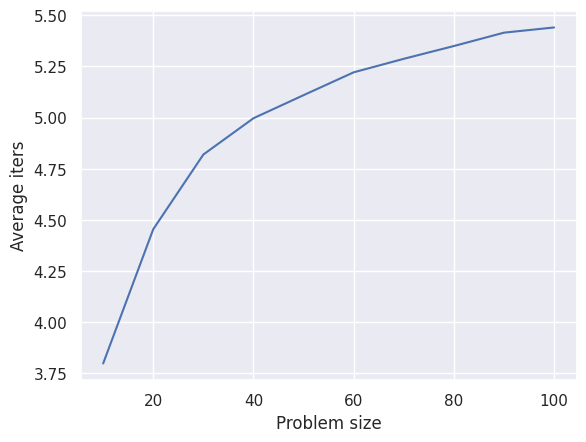

In [ ]:
ax = sns.lineplot(y=stats["Average iters"], x=stats.index)
ax.set_xlabel('Problem size')

Text(0.5, 0, 'Problem size')

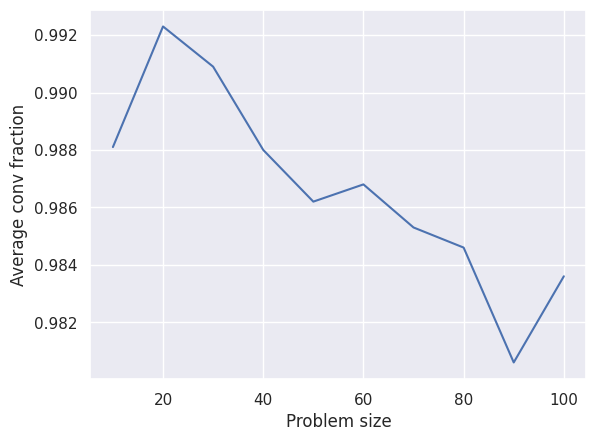

In [ ]:
ax = sns.lineplot(y=stats["Average conv fraction"], x=stats.index)
ax.set_xlabel('Problem size')

Text(0, 0.5, 'Average time, ms')

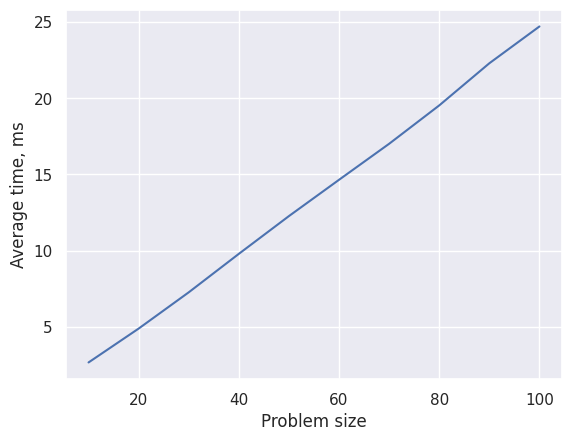

In [ ]:
ax = sns.lineplot(y=stats["Average time"], x=stats.index)
ax.set_xlabel('Problem size')
ax.set_ylabel('Average time, ms')

Text(0.5, 0, 'Problem size')

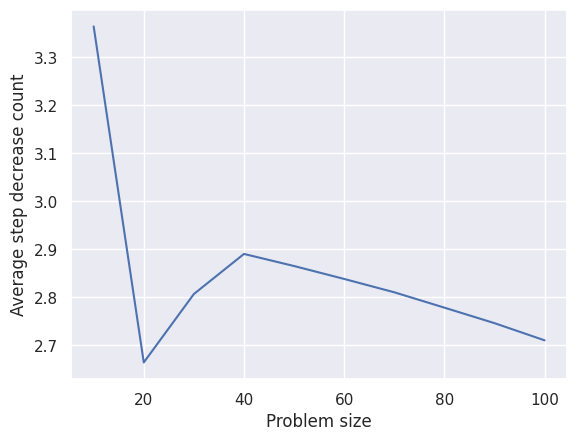

In [ ]:
ax = sns.lineplot(y=stats["Average step decrease count"], x=stats.index)
ax.set_xlabel('Problem size')

In [ ]:
def calc_ith_errors(i):
  n_starts = 100
  eps = 0.01
  max_iters = 25
  n, m = n_range[0], m_range[0]

  beta = 0.5
  alpha = 0

  diffs = np.zeros(shape=(max_iters))
  count_not_conv = np.zeros(shape=(max_iters))

  pbar = tqdm.tqdm(total=n_starts, position=0, leave=True)
  for start in range(n_starts):
      A = data[n][i]["A"]
      b = data[n][i]["b"]
      x = data[n][i][f"x_{start}"].copy()
      mu = np.zeros(shape=(m))
      y_true = data[n][i]["y_true"]

      iter_cnt = 0
      count_not_conv[iter_cnt] += 1
      diffs[iter_cnt] += np.abs(calc_f(x) - y_true)
      while not np.isclose(calc_f(x), y_true, atol=eps):
          delta = iter_newton(x, mu, A, b)
          delta_x, delta_mu = delta[:x.shape[0]], delta[x.shape[0]:]

          t = 1
          while check_step_condition(x, mu, A, b, alpha, t, delta_x, delta_mu):
            t = beta * t
          x += t*delta_x
          mu += t*delta_mu

          iter_cnt += 1
          if iter_cnt == max_iters:
              break
          diffs[iter_cnt] += np.abs(calc_f(x) - y_true)
          count_not_conv[iter_cnt] += 1
      pbar.update(1)
  return diffs, count_not_conv


100%|██████████| 100/100 [00:00<00:00, 547.14it/s]
/tmp/ipykernel_34/945500274.py:2: RuntimeWarning: invalid value encountered in divide
  precision = pd.DataFrame({"Sum error": diffs, "Average error": diffs / count_not_conv})


Text(0, 0.5, 'Error')

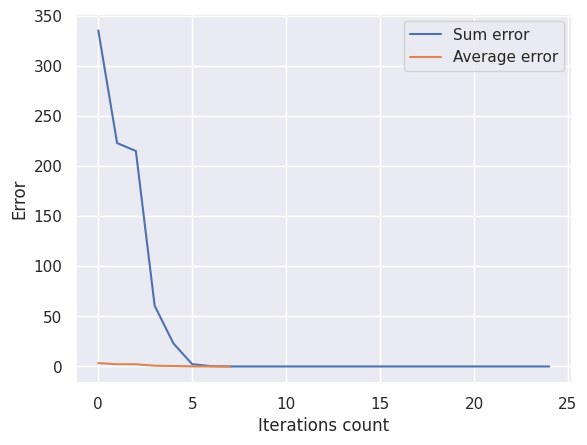

In [ ]:
diffs, count_not_conv = calc_ith_errors(20)
precision = pd.DataFrame({"Sum error": diffs, "Average error": diffs / count_not_conv})
ax = precision.plot()
ax.set_xlabel('Iterations count')
ax.set_ylabel('Error')

/tmp/ipykernel_34/976481379.py:1: RuntimeWarning: invalid value encountered in divide
  precision = pd.DataFrame({"Average error": diffs / count_not_conv})


Text(0, 0.5, 'Error')

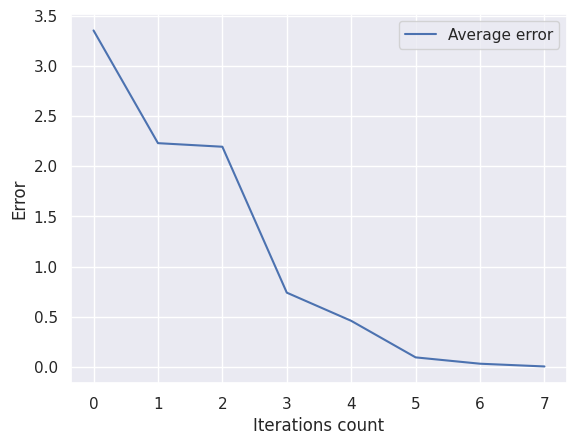

In [ ]:
precision = pd.DataFrame({"Average error": diffs / count_not_conv})
ax = precision.plot()
ax.set_xlabel('Iterations count')
ax.set_ylabel('Error')

100%|██████████| 100/100 [00:00<00:00, 583.27it/s]
/tmp/ipykernel_34/3327586054.py:2: RuntimeWarning: invalid value encountered in divide
  precision = pd.DataFrame({"Sum error": diffs, "Average error": diffs / count_not_conv})


Text(0, 0.5, 'Error')

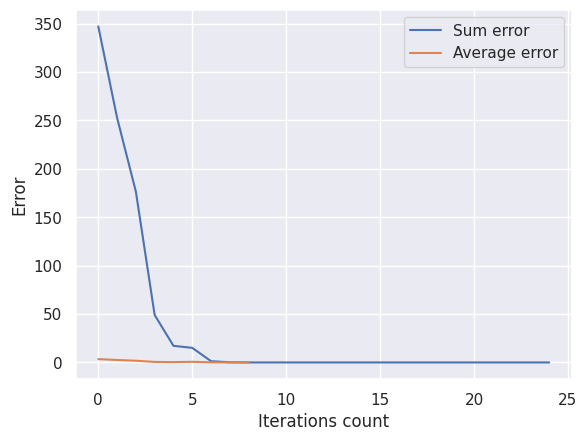

In [ ]:
diffs, count_not_conv = calc_ith_errors(56)
precision = pd.DataFrame({"Sum error": diffs, "Average error": diffs / count_not_conv})
ax = precision.plot()
ax.set_xlabel('Iterations count')
ax.set_ylabel('Error')

100%|██████████| 100/100 [00:00<00:00, 640.96it/s]
/tmp/ipykernel_34/3464020711.py:2: RuntimeWarning: invalid value encountered in divide
  precision = pd.DataFrame({"Sum error": diffs, "Average error": diffs / count_not_conv})


Text(0, 0.5, 'Error')

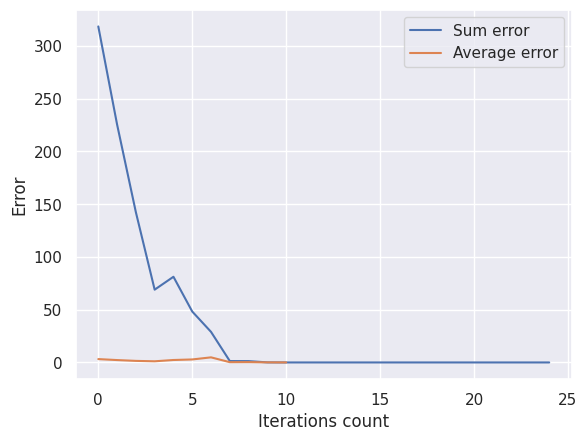

In [ ]:
diffs, count_not_conv = calc_ith_errors(95)
precision = pd.DataFrame({"Sum error": diffs, "Average error": diffs / count_not_conv})
ax = precision.plot()
ax.set_xlabel('Iterations count')
ax.set_ylabel('Error')